# Student Starter Code
### CS 181 Practical, Spring 2021
author: njohnson

**Please copy this notebook by clicking "File" -> "Save a Copy in Drive".**

This notebook contains starter code to:


*   **Load all of the data files** directly into your Colab runtime from the GCP bucket (so you don't need to download them to your computer!)
*   **Install libraries** inline, so you don't need to install them to your computer!




# Before you run this code:

1.   **Change your Runtime to use a GPU**: Click "Runtime" -> "Change Runtime Type", and select "GPU".
2.   **Stop Colab from disconnecting**:  To prevent Google Colab from disconnecting while you're away,  you can add an auto-click function using the Chrome console Just "Inspect", navigate to the "Console" and paste in this function:

```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("#ok").click()
}
setInterval(ClickConnect,60000)
```







In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Load the data files into local memory from the GCP bucket.

In [ ]:
!gsutil cp gs://cs181_practical_data/Xtrain_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytest_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtrain_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_mel.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytest_mel.npy ./

Copying gs://cs181_practical_data/Xtrain_amp.npy...
| [1 files][934.2 MiB/934.2 MiB]   41.8 MiB/s                                   
Operation completed over 1 objects/934.2 MiB.                                    
Copying gs://cs181_practical_data/ytrain_amp.npy...
/ [1 files][ 43.5 KiB/ 43.5 KiB]                                                
Operation completed over 1 objects/43.5 KiB.                                     
Copying gs://cs181_practical_data/Xtest_amp.npy...
- [1 files][369.6 MiB/369.6 MiB]                                                
Operation completed over 1 objects/369.6 MiB.                                    
Copying gs://cs181_practical_data/ytest_amp.npy...
/ [1 files][ 17.3 KiB/ 17.3 KiB]                                                
Operation completed over 1 objects/17.3 KiB.                                     
Copying gs://cs181_practical_data/Xtrain_mel.npy...
- [1 files][235.9 MiB/235.9 MiB]                                                
Operation

### Load raw amplitude data as a numpy object.

In [ ]:
# Load train data

X_amp_train = np.load("Xtrain_amp.npy")
y_amp_train = np.load("ytrain_amp.npy")

In [ ]:
X_amp_train.shape

(5553, 44100)

In [ ]:
# Load test data

X_amp_test = np.load("Xtest_amp.npy")
y_amp_test = np.load("ytest_amp.npy")

In [ ]:
X_amp_test.shape

(2197, 44100)

### Load Mel spectrogram data as a numpy object.

In [ ]:
# Load train data

X_mel_train = np.load("Xtrain_mel.npy")
y_mel_train = np.load("ytrain_mel.npy")

In [ ]:
X_mel_train.shape

(5553, 128, 87)

In [ ]:
# Flatten X_mel_train's spectrogram features
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
X_mel_train_flat.shape

(5553, 11136)

In [ ]:
# Load test data

X_mel_test = np.load("Xtest_mel.npy")
y_mel_test = np.load("ytest_mel.npy")

In [ ]:
X_mel_test_flat = X_mel_test.reshape(X_mel_test.shape[0], -1)
X_mel_test.shape

(2197, 128, 87)

### Delete an object from local memory.

The "del" keyword in Python is used to dereference objects from local memory.  You can use it to save memory by getting rid of variables that you don't intend to use anymore.

For example, to delete the variable X_mel_train:

In [ ]:
# del X_mel_train

### Example package installation

You can install packages using pip by running lines of code preceded by "!".  For example, the below line of code installs the librosa package:

In [ ]:
! pip install librosa

In [ ]:
# After you've installed a package, you can import it
import librosa

In [ ]:
import librosa.display

In [ ]:
import matplotlib.pyplot as plt
def plot_spec(y):
    '''Adapted from librosa documentation'''
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    hop_length = 2048
    img = librosa.display.specshow(y, y_axis='log', hop_length=hop_length, x_axis='time', ax=ax)
    ax.set(title='Log-frequency power spectrogram')
    ax.label_outer()
    fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
y_mel_test[12]

2

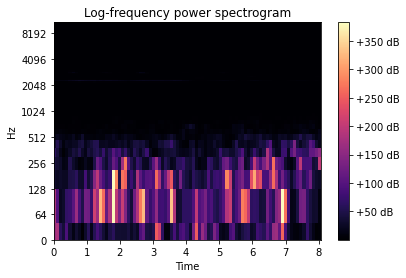

In [ ]:
plot_spec(X_mel_test[12])

# PCA to Logistic Regression

In [ ]:
import sklearn.decomposition

NUM_COMPONENTS = 500
NUM_CLASSES = 10
CLASSNAMES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot",
              "jackhammer", "siren", "street_music"]

# Computes PCA and projects design matrix into parameter space
pca_amp = sklearn.decomposition.PCA(NUM_COMPONENTS)
X_amp_proj_train = pca_amp.fit_transform(X_amp_train) 

# Computes PCA and projects design matrix into parameter space
pca_mel = sklearn.decomposition.PCA(NUM_COMPONENTS)
X_mel_proj_train = pca_mel.fit_transform(X_mel_train_flat)

In [ ]:
# Get % of variation explained in each
amp_var_explained = np.sum(pca_amp.explained_variance_ratio_)
mel_var_explained = np.sum(pca_mel.explained_variance_ratio_)

print(f"Variation explained by first 500 modes for amp data: {amp_var_explained}")
print(f"Variation explained by first 500 modes for mel data: {mel_var_explained}")

Variation explained by first 500 modes for amp data: 0.6018065214157104
Variation explained by first 500 modes for mel data: 0.9792006015777588


## Grid Search

In [ ]:
# Grid search adapted from https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [0.1, 1, 10],
          'class_weight': [None, 'balanced'],
          'max_iter': [1000, 10000, 100000]
          }

In [ ]:
def accuracy(model, X, Y):
    """Computes class accuracies and overall accuracy"""
    predictions = model.predict(X)

    # Get vector of counts of true y labels
    class_counts = np.array([np.count_nonzero(Y == i) for i in range(NUM_CLASSES)])

    # Count hits
    TP_counts = np.zeros(NUM_CLASSES)
    for prediction, y in zip(predictions, Y):
        if prediction == y:
            TP_counts[y] += 1

    # Compute accuracy
    total_acc = np.sum(TP_counts) / len(X)

    # Class accuracies: each TP_count divided by respective class_count
    class_acc = np.array([tp / class_count for tp, class_count in zip(TP_counts, class_counts)])
    return class_acc, total_acc 

### Grid search LR on amp data

In [ ]:
# amp_model = LogisticRegression()
# amp_gridsearch = GridSearchCV(amp_model, params, cv=3, verbose=3)
# amp_gridsearch.fit(X_amp_proj_train, y_amp_train)
# log_amp_model = amp_gridsearch.best_estimator_

### Grid search LR on mel data

In [ ]:
# mel_model = LogisticRegression()
# mel_gridsearch = GridSearchCV(mel_model, params, cv=3, verbose=3)
# mel_gridsearch.fit(X_mel_proj_train, y_mel_train)
# log_mel_model = mel_gridsearch.best_estimator_

In [ ]:
# import pickle

# pickle.dump(log_amp_model, open("log_amp_model.p", "wb"))
# pickle.dump(log_mel_model, open("log_mel_model.p", "wb"))

In [ ]:
import pickle

log_amp_model = pickle.load(open( "log_amp_model.p", "rb" ))
log_mel_model = pickle.load(open( "log_mel_model.p", "rb" ))

## Train/Test results

In [ ]:

print("Best model: ", log_amp_model)
print("Accuracy:", accuracy(log_amp_model, X_amp_proj_train, y_amp_train))

Best model:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: (array([0.28571429, 0.11675127, 0.54166667, 0.14913958, 0.15980231,
       0.28710125, 0.38554217, 0.25227964, 0.28742515, 0.27714286]), 0.2820097244732577)


In [ ]:
print("Best model: ", log_mel_model)
print("Accuracy on train set:", accuracy(log_mel_model, X_mel_proj_train, y_mel_train))

Best model:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy on train set: (array([0.44285714, 0.72081218, 0.55890805, 0.4416826 , 0.54200988,
       0.48266297, 0.60240964, 0.58358663, 0.54640719, 0.37428571]), 0.5060327750765352)


In [ ]:
# Project test data onto PC

# Amplitude data
X_amp_test_proj = pca_amp.transform(X_amp_test) 

# Spectrogram data
X_mel_test_flat = X_mel_test.reshape(X_mel_test.shape[0], -1)
X_mel_test_flat_proj = pca_mel.transform(X_mel_test_flat)

In [ ]:
# Get test accuracies

amp_test_accuracies = accuracy(log_amp_model, X_amp_test_proj, y_amp_test)
print("Amplitude test accuracies:", amp_test_accuracies[1], np.around(amp_test_accuracies[0], 3))

mel_test_accuracies = accuracy(log_mel_model, X_mel_test_flat_proj, y_mel_test)
print("Spectrogram test accuracies:", mel_test_accuracies[1], np.around(mel_test_accuracies[0], 3))

Amplitude test accuracies: 0.1943559399180701 [0.23  0.    0.652 0.057 0.049 0.14  0.    0.123 0.11  0.15 ]
Spectrogram test accuracies: 0.3131543013199818 [0.21  0.538 0.532 0.188 0.33  0.348 0.533 0.203 0.487 0.147]


In [ ]:
import matplotlib.pyplot as plt

# adapted from https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb
def plot_confusion_matrix(matrix, save=False, filename=None):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    if save:
        assert filename != None
        plt.savefig(filename)

def class_accuracy_barplots(list1, list2, label1, label2):
    assert len(list1) == len(list2)
    ind = np.arange(len(list1))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12,6))
    rects1 = ax.bar(ind - width/2, list1, width, label=label1, color='mediumpurple')
    rects2 = ax.bar(ind + width/2, list2, width, label=label2, color='paleturquoise')
    ax.set_ylabel('Accuracy')
    ax.set_title('Class Accuracies')
    ax.set_xticks(ind)
    ax.set_xticklabels([str(i) for i in range(len(list1))])
    ax.legend()
    plt.show()

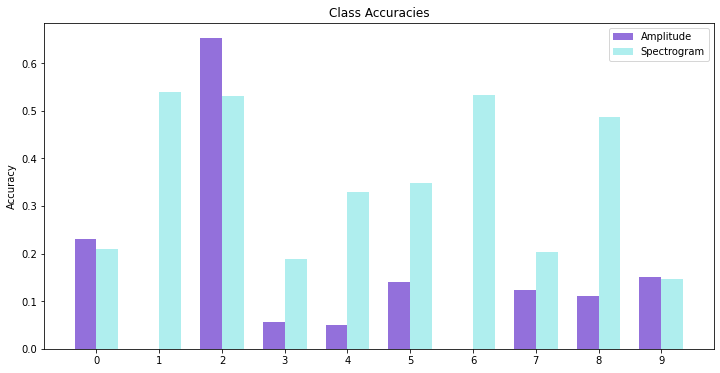

In [ ]:
class_accuracy_barplots(amp_test_accuracies[0], mel_test_accuracies[0], "Amplitude", "Spectrogram")

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import time
import pandas as pd
import itertools
from tqdm import tqdm

rs = 42

In [ ]:
forest_clf_amp = RandomForestClassifier(n_estimators=10, random_state=rs) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_amp.fit(X_amp_train, y_amp_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_amp_train, forest_clf_amp.predict(X_amp_train)))
print("Accuracy score on test data: ", accuracy_score(y_amp_test, forest_clf_amp.predict(X_amp_test)))

forest_clf_mel = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=None) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_mel.fit(X_mel_train_flat, y_amp_train)

# testing accuracy for spectrogram data
print("Accuracy score on train data: ", accuracy_score(y_mel_train, forest_clf_mel.predict(X_mel_train_flat)))
print("Accuracy score on test data: ", accuracy_score(y_mel_test, forest_clf_mel.predict(X_mel_test_flat)))

NameError: ignored

In [ ]:
amp_pred = forest_clf_amp.predict(X_amp_test)
mel_pred = forest_clf_mel.predict(X_mel_test_flat)

In [ ]:
# Per-class accuracy
import collections

def calculate_class_accuracies(y_test, y_hat):
    class_totals = collections.Counter(y_test)
    class_accuracies = [class_totals[i] for i in range(0, len(class_totals))]

    for i in range(len(y_hat)):
        if y_hat[i] != y_test[i]:
            class_accuracies[y_test[i]] -= 1

    class_accuracies_per = [round((class_accuracies[i] / class_totals[i]) * 100, 1) for i in range(0, len(class_totals))]
    return class_accuracies_per

In [ ]:
print("Amplitude per-class accuracy", calculate_class_accuracies(y_amp_test, amp_pred))
print("Spectrogram per-class accuracy", calculate_class_accuracies(y_mel_test, mel_pred))

## Grid Search

In [ ]:
# Using Grid Search
param_grid = [
              {'max_depth': [10, 50, None], 
               'max_features': ['auto', 'sqrt', 'log2'], 
               'min_samples_leaf': [10, 20, 50], 
               'max_samples': [0.5, 0.9, 1]}
]

forest_clf_amp = RandomForestClassifier(n_estimators=10, random_state=rs) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_amp.fit(X_amp_train, y_amp_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_amp_train, forest_clf_amp.predict(X_amp_train)))
print("Accuracy score on test data: ", accuracy_score(y_amp_test, forest_clf_amp.predict(X_amp_test)))

# GridSearchCV
CV_rfc = GridSearchCV(estimator=forest_clf_amp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10, scoring="accuracy")
CV_rfc.fit(X_amp_train, y_amp_train)

In [ ]:
print(CV_rfc.best_params_)
df = pd.DataFrame(CV_rfc.cv_results_)
print(df)

In [ ]:
max_depth, max_features, min_samples_leaf, max_samples = CV_rfc.best_params_['max_depth'], CV_rfc.best_params_['max_features'], CV_rfc.best_params_['min_samples_leaf'], CV_rfc.best_params_['max_samples']

# print accuracy of the best model
forest_clf_amp = RandomForestClassifier(n_estimators=10, random_state=rs, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, max_samples=max_samples) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_amp.fit(X_amp_train, y_amp_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_amp_train, forest_clf_amp.predict(X_amp_train)))
print("Accuracy score on test data: ", accuracy_score(y_amp_test, forest_clf_amp.predict(X_amp_test)))

In [ ]:
# train Random Forests on normal inputs
forest_clf_mel = RandomForestClassifier(n_estimators=10, random_state=rs) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_mel.fit(X_mel_train_flat, y_mel_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_mel_train, forest_clf_mel.predict(X_mel_train_flat)))
print("Accuracy score on test data: ", accuracy_score(y_mel_test, forest_clf_mel.predict(X_mel_test_flat)))

# GridSearchCV
CV_rfc_mel = GridSearchCV(estimator=forest_clf_mel, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10, scoring="accuracy")
CV_rfc_mel.fit(X_mel_train_flat, y_mel_train)

In [ ]:
print(CV_rfc_mel.best_params_)
df_mel = pd.DataFrame(CV_rfc_mel.cv_results_)
print(df_mel)

In [ ]:
max_depth, max_features, min_samples_leaf, max_samples = CV_rfc_mel.best_params_['max_depth'], CV_rfc_mel.best_params_['max_features'], CV_rfc_mel.best_params_['min_samples_leaf'], CV_rfc_mel.best_params_['max_samples']
print(max_depth, max_features, min_samples_leaf)
# print accuracy of the best model
forest_clf_mel = RandomForestClassifier(n_estimators=10, random_state=rs, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, max_samples=max_samples) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_mel.fit(X_mel_train_flat, y_mel_train)

# testing accuracy for mel data
print("Accuracy score on train data: ", accuracy_score(y_mel_train, forest_clf_mel.predict(X_mel_train_flat)))
print("Accuracy score on test data: ", accuracy_score(y_mel_test, forest_clf_mel.predict(X_mel_test_flat)))

In [ ]:
# LAST HYPERPARAMETER TUNING - CHANGING THE INPUT: PCA
# Hyperparameter optimization: decreasing input features through PCA, features = 500

NUM_COMPONENTS = 5000

# Computes PCA and projects design matrix into parameter space
pca_amp = PCA(n_components=NUM_COMPONENTS)
X_amp_train_proj_500 = pca_amp.fit_transform(X_amp_train) 
X_amp_test_proj_500 = pca_amp.transform(X_amp_test)

In [ ]:
# Using Grid Search
param_grid = [
              {'max_depth': [10, 50, None], 
               'max_features': ['auto', 'sqrt', 'log2'], 
               'min_samples_leaf': [10, 20, 50], 
               'max_samples': [0.5, 0.9, 1]}
]

forest_clf_amp = RandomForestClassifier(n_estimators=10, random_state=rs) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_amp.fit(X_amp_train_proj_500, y_amp_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_amp_train, forest_clf_amp.predict(X_amp_train_proj_500)))
print("Accuracy score on test data: ", accuracy_score(y_amp_test, forest_clf_amp.predict(X_amp_test_proj_500)))

# GridSearchCV
CV_rfc = GridSearchCV(estimator=forest_clf_amp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10, scoring="accuracy")
CV_rfc.fit(X_amp_train_proj_500, y_amp_train)

print(CV_rfc.best_params_)
df = pd.DataFrame(CV_rfc.cv_results_)
print(df)

In [ ]:
max_depth, max_features, min_samples_leaf, max_samples = CV_rfc.best_params_['max_depth'], CV_rfc.best_params_['max_features'], CV_rfc.best_params_['min_samples_leaf'], CV_rfc.best_params_['max_samples']
print(max_depth, max_features, min_samples_leaf)
# print accuracy of the best model
forest_clf_amp = RandomForestClassifier(n_estimators=10, random_state=rs, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, max_samples=max_samples) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_amp.fit(X_amp_train_proj_500, y_amp_train)

# testing accuracy for amp data
print("Accuracy score on train data: ", accuracy_score(y_amp_train, forest_clf_amp.predict(X_amp_train_proj_500)))
print("Accuracy score on test data: ", accuracy_score(y_amp_test, forest_clf_amp.predict(X_amp_test_proj_500)))

In [ ]:
# MEL PCA
pca_mel = PCA(n_components=NUM_COMPONENTS)
X_mel_train_proj_500 = pca_mel.fit_transform(X_mel_train_flat)
X_mel_test_proj_500 = pca_mel.transform(X_mel_test_flat)

In [ ]:
# Using Grid Search
forest_clf_mel = RandomForestClassifier(n_estimators=10, random_state=rs) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_mel.fit(X_mel_train_proj_500, y_mel_train)

# testing accuracy for mel data
print("Accuracy score on train data: ", accuracy_score(y_mel_train, forest_clf_mel.predict(X_mel_train_proj_500)))
print("Accuracy score on test data: ", accuracy_score(y_mel_test, forest_clf_mel.predict(X_mel_test_proj_500)))

# GridSearchCV
CV_rfc = GridSearchCV(estimator=forest_clf_mel, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10, scoring="accuracy")
CV_rfc.fit(X_mel_train_proj_500, y_mel_train)

print(CV_rfc.best_params_)
df = pd.DataFrame(CV_rfc.cv_results_)
print(df)

In [ ]:
max_depth, max_features, min_samples_leaf, max_samples = CV_rfc.best_params_['max_depth'], CV_rfc.best_params_['max_features'], CV_rfc.best_params_['min_samples_leaf'], CV_rfc.best_params_['max_samples']

# print accuracy of the best model
forest_clf_mel = RandomForestClassifier(n_estimators=10, random_state=rs, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, max_samples=max_samples) # n_estimators = number of trees, random_state = seed in RNG (None=no seed, alwasy different RNGs)
forest_clf_mel.fit(X_mel_train_proj_500, y_mel_train)

# testing accuracy for mel data
print("Accuracy score on train data: ", accuracy_score(y_mel_train, forest_clf_mel.predict(X_mel_train_proj_500)))
print("Accuracy score on test data: ", accuracy_score(y_mel_test, forest_clf_mel.predict(X_mel_test_proj_500)))

# CNN

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Set up transformation process for images
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Construct data loaders from existing numpy arrays
# Code adapted from https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
def np_to_dataset(X, Y):
    return TensorDataset(torch.Tensor(X), torch.Tensor(Y).long())


train_dataset = np_to_dataset(X_mel_train, y_mel_train)
test_dataset = np_to_dataset(X_mel_test, y_mel_test)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=True, num_workers=0)

# Hardware acceleration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(384, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []
for epoch in range(120):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)#
        labels = labels.to(device)#
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    train_losses.append(running_loss / 5553)
    print('[Epoch %d] average train loss: %.4f' % (epoch + 1, running_loss / 5553))
    
    ## Calculate test loss in similar fashion
    net.train(False)
    running_test_loss = 0.0
    for i, data in enumerate(testloader, 0):
        xs, ys = data
        xs = xs.to(device)
        ys = ys.to(device)
        outputs = net(xs)
        #outputs = outputs.to(device)#
        loss = criterion(outputs, ys)
        running_test_loss += loss.item()

    test_losses.append(running_test_loss / 2197)
    print('[Epoch %d] average test loss: %.3f' % (epoch + 1, running_test_loss / 2197))

print('Finished Training')

RuntimeError: ignored

In [ ]:
NUM_CLASSES = 10
CLASSNAMES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot",
              "jackhammer", "siren", "street_music"]

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)#
        labels = labels.to(device)#
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)#
        labels = labels.to(device)#
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        CLASSNAMES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the test images: 32 %
Accuracy of air_conditioner :  5 %
Accuracy of car_horn :  0 %
Accuracy of children_playing : 16 %
Accuracy of dog_bark : 41 %
Accuracy of drilling : 20 %
Accuracy of engine_idling : 23 %
Accuracy of gun_shot : 20 %
Accuracy of jackhammer : 95 %
Accuracy of siren : 46 %
Accuracy of street_music : 51 %


In [ ]:
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)

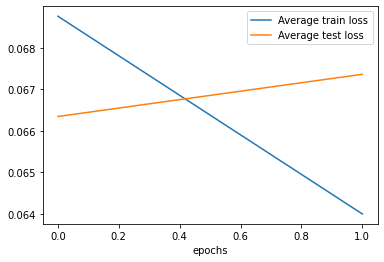

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Average train loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("epochs")
plt.legend()
plt.savefig('cnn_losses.png')
plt.show()

### Compute accuracies

In [ ]:
NUM_CLASSES = 10
CLASSNAMES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot",
              "jackhammer", "siren", "street_music"]

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        CLASSNAMES[i], 100 * class_correct[i] / class_total[i]))

### Grid Search

In [ ]:
# Grid search
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Parameterize the CNN dense layer 2
class NetPrime(nn.Module):
    # Adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    def __init__(self, pen_layer_size):
        super(NetPrime, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(384, pen_layer_size)
        self.fc2 = nn.Linear(pen_layer_size, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(pen_layer_size, lr, epochs, trainloader, testloader, verbose=False):
    net = NetPrime(pen_layer_size=pen_layer_size)
    if torch.cuda.is_available():
        net.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    train_losses = []
    test_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        train_losses.append(running_loss / 5553)
        if verbose:
            print('[Epoch %d] average train loss: %.4f' % (epoch + 1, running_loss / 5553))
        
        ## Calculate test loss in similar fashion
        net.train(False)
        running_test_loss = 0.0
        for i, data in enumerate(testloader, 0):
            xs, ys = data
            xs = xs.to(device)
            ys = ys.to(device)

            outputs = net(xs)
            loss = criterion(outputs, ys)
            running_test_loss += loss.item()

        test_losses.append(running_test_loss / 2197)
        if verbose:
            print('[Epoch %d] average test loss: %.3f' % (epoch + 1, running_test_loss / 2197))

    print('Finished Training')
    return {'train_losses': train_losses, 'test_losses': test_losses, 'model': net}

def net_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            CLASSNAMES[i], 100 * class_correct[i] / class_total[i]))
        
def train_and_evaluate(pen_layer_size, lr, epochs, trainloader, testloader):
    results = train_model(pen_layer_size, lr, epochs, trainloader, testloader)
    net_accuracy(results['model'], testloader)
    return results

In [ ]:
import itertools
pen_layer_sizes = [5, 10, 25, 50, 100]
epochs = [100]
lrs = [0.01, 0.001]
trainloaders = [trainloader]
testloaders = [testloader]

gs_results = {}
for params in itertools.product(pen_layer_sizes, lrs, epochs, trainloaders, testloaders):
    print(f"Params training: {params}")
    gs_results[tuple(params)] = train_and_evaluate(*params)



In [ ]:
import pickle
from google.colab import files

pickle.dump(gs_results, open("cnn_gs_results.p", "wb"))
files.download('cnn_gs_results.p') 

In [ ]:
# Get test samples from class 1 (0% accuracy)
x_mel_1 = torch.Tensor(X_mel_test[np.where(y_mel_test == 1)]).to(device)

# Get predictions on those samples
net.train(False)
y_preds = net(x_mel_1).cpu()
y_preds = y_preds.detach()
y_preds = y_preds.numpy().argmax(axis=1)
y_preds = [np.count_nonzero(y_preds == i) for i in range(NUM_CLASSES)]
print(y_preds)

# Create a bar plot

In [ ]:
def prediction_spread(preds, num_categories, true_class):
    xlabs = list(range(num_categories))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(xlabs, preds)
    ax.set_xticks(xlabs)
    ax.set_xticklabels([str(i) for i in range(num_categories)])
    ax.set_ylabel('Count')
    ax.set_xlabel('Classes')
    ax.set_title(f'Class Predicted (true class = {true_class})')
    plt.show()

prediction_spread(y_preds, NUM_CLASSES, true_class=1)


# Data Augmentation

In [ ]:
class_dict = {0 : "air_conditioner", 
              1 : "car_horn",
              2 : "children_playing",
              3 : "dog_bark",
              4 : "drilling",
              5 : "engine_idling",
              6 : "gun_shot",
              7 : "jackhammer",
              8 : "siren",
              9 : "street_music"}

In [ ]:
# add noise
import numpy as np
np.random.seed(0) # reset the seed
def add_noise(data, noise_factor):
    noise = np.random.randn(data.shape[1])
    augmented_data = np.empty((data.shape[0], data.shape[1]))
    for i in range(data.shape[0]):
        augmented_data[i] = data[i] + noise_factor * noise
    # Cast back to same data type
    # augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

X_amp_train_noise = add_noise(X_amp_train, 0.05)

In [ ]:
# view the difference between raw and noise data
num = 30
print(class_dict[y_amp_train[num]])
plot_amp(X_amp_train[num])
plot_amp(X_amp_train_noise[num])

In [ ]:
# add noise data to raw data
X_amp_train_noise_comb = np.append(X_amp_train, X_amp_train_noise, axis=0)
y_amp_train_noise = np.append(y_amp_train, y_amp_train, axis=0)

In [ ]:
# time shift code
def time_shift(data, sampling_rate, shift_max, shift_direction):
    augmented_data = np.empty((data.shape[0], data.shape[1]))
    for i in range(data.shape[0]):
        shift = np.random.randint(sampling_rate * shift_max)
        if shift_direction == 'right':
            shift = -shift
        elif shift_direction == 'both':
            direction = np.random.randint(0, 2)
            if direction == 1:
                shift = -shift
        augmented_data[i] = np.roll(data[i], shift)
    return augmented_data

In [ ]:
X_amp_train_time = time_shift(X_amp_train, 0.5, X_amp_train.shape[1], 'both')

In [ ]:
# view the difference between raw and noise data
num = 29
print(class_dict[y_amp_train[num]])
plot_amp(X_amp_train[num])
plot_amp(X_amp_train_time[num])

In [ ]:
# combine both raw, noise, and time data
X_amp_train_time_comb = np.append(X_amp_train, X_amp_train_time, axis=0)
X_amp_train_comb = np.append(X_amp_train_noise, X_amp_train_time_comb, axis=0)
y_amp_train_comb = np.append(y_amp_train_noise, y_amp_train, axis=0)
print(X_amp_train_comb.shape)
# run X_amp_train_comb on Rnadom Forest